In [196]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import tarfile

In [197]:
tf.get_logger().setLevel("ERROR")

In [198]:
DATASETS_DIR = "data"
DATASETS_TGZ = "datasets.tgz"
UNPACKED_DIR = os.path.join("data", "unpacked")

In [199]:
os.makedirs(UNPACKED_DIR, exist_ok=True)
tgz_path = os.path.join(DATASETS_DIR, DATASETS_TGZ)
dataset_tgz = tarfile.open(tgz_path)
dataset_tgz.extractall(path=UNPACKED_DIR)
dataset_tgz.close()

In [200]:
def read_csv_dataset(name, path=UNPACKED_DIR):
    csv_path = os.path.join(path, name + ".csv")
    return pd.read_csv(csv_path)

def read_images_dataset(name, path=UNPACKED_DIR, train_split=0.75, val_split=0.15):
    test_split = 1 - train_split - val_split
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, name),
        labels='inferred',
        label_mode='categorical',
        color_mode="rgb",
        batch_size=32,
        seed=42
    )
    train_dataset = dataset.take(int(len(dataset) * train_split))
    val_test_dataset = dataset.skip(int(len(dataset) * train_split))
    val_dataset = val_test_dataset.take(int(len(val_test_dataset) * (val_split / (val_split + test_split))))
    test_dataset = val_test_dataset.skip(int(len(val_test_dataset) * (val_split / (val_split + test_split))))
    return train_dataset, val_dataset, test_dataset

titanic_dataset = read_csv_dataset("Titanic")
diamonds_dataset = read_csv_dataset("diamonds")
weather_dataset = read_images_dataset("weather-image")

Found 6862 files belonging to 11 classes.


## From Biological to Artificial Neurons

#### The Perceptron

In [201]:
from sklearn.linear_model import Perceptron

iris = titanic_dataset
iris.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [202]:
iris["Sex"] = (iris["Sex"] == "male").astype(np.int32)
X, y = iris[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]], iris["Survived"]
X_train, X_test = X.iloc[5:], X.iloc[:5]
y_train, y_test = y.iloc[5:], y.iloc[:5]

In [203]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

per_clf = Perceptron(random_state=42, n_iter_no_change=100)
per_clf.fit(X_train, y_train)

y_pred = per_clf.predict(X_test)
y_pred

array([0, 1, 1, 1, 0], dtype=int64)

## Implementing MLPs with Keras

#### Building an Image Classifier Using the Sequential API

##### Using Keras to load the dataset

In [204]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [205]:
X_train_full.shape

(60000, 28, 28)

In [206]:
X_train_full.dtype

dtype('uint8')

In [207]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [208]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [209]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

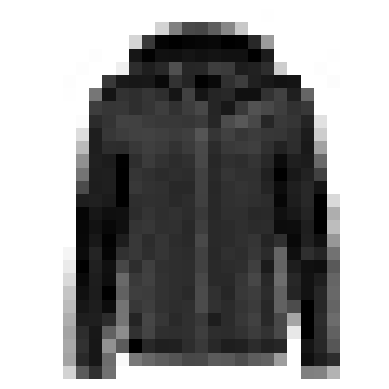

'Coat'

In [210]:
from matplotlib import pyplot as plt

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()
class_names[y_train[0]]

##### Creating the model using the Sequential API

In [211]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [212]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [213]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [214]:
model.layers

In [215]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [216]:
model.get_layer("dense") is hidden1

True

In [217]:
weights, biases = hidden1.get_weights()

In [218]:
weights.shape

(784, 300)

In [219]:
biases.shape

(300,)

##### Compiling the model

In [220]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

##### Training and evaluating the model

In [221]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1694/1719 [============================>.] - ETA: 0s - loss: 0.7253 - accuracy: 0.7644

KeyboardInterrupt: 

In [ ]:
history.params

In [ ]:
len(history.epoch)

In [ ]:
history.history.keys()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

##### Using the model to make predictions

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new, verbose=0)
y_proba.round(2)

In [ ]:
y_pred = np.argmax(model.predict(X_new, verbose=0), axis=-1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3]
y_new

#### Building a Regression MLP Using the Sequential API

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:3]
y_pred = model.predict(X_new, verbose=0)
y_pred

In [ ]:
y_new = y_test[:3]
y_new

#### Building Complex Models Using the Functional API

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid));

In [ ]:
model.evaluate((X_test_A, X_test_B), y_test)

In [ ]:
y_pred = model.predict((X_new_A, X_new_B), verbose=0)
y_pred

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
          validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]));

In [ ]:
model.evaluate([X_test_A, X_test_B], [y_test, y_test]) # total_loss, main_loss, aux_loss

In [ ]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

#### Using the Subclassing API to Build Dynamic Models

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs, training=None, mask=None):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [ ]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=20, 
          validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)));

In [ ]:
model.evaluate((X_test_A, X_test_B), (y_test, y_test)) # total_loss, main_loss, aux_loss

In [ ]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

#### Saving and Restoring a Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid));

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_new, verbose=0)
y_pred

In [ ]:
model.save("temp_model.keras")
model = keras.models.load_model("temp_model.keras")

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_new, verbose=0)
y_pred

#### Using Callbacks

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("temp_model.keras", save_best_only=True)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb]);

In [ ]:
model = keras.models.load_model("temp_model.keras") # rollback to best model

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, early_stopping_cb]);

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()

In [ ]:
model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid), 
          callbacks=[val_train_ratio_cb], verbose=2);

#### Using TensorBoard for Visualization

```tensorboard --logdir=lab9/logs --port=6006```

In [ ]:
def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, tensorboard_cb]);

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-2))
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, tensorboard_cb]);

## Fine-Tuning Neural Network Hyperparameters

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=None):
    if input_shape is None:
        input_shape = [8]
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=None,
                           callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

In [ ]:
keras_reg.score(X_test, y_test) # R^2 value

In [ ]:
y_pred = keras_reg.predict(X_new, verbose=0)
y_pred

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
}

keras_reg.verbose = 0
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_ # R^2 value

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test) # R^2 value

In [ ]:
rnd_search_cv.predict(X_new)